In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import numpy as np
import warnings
from torchvision import transforms
from torchsummary import summary
from torchvision.io import read_image
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchvision import datasets, models, transforms
warnings.filterwarnings('ignore')
from PIL import Image

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# считываем датасет, и делим его на выборки для трейн, теста и валида
df = pd.read_csv('/content/drive/MyDrive/2_semestr/PP/3_class.csv')
train_val, test = train_test_split(df, test_size=0.2, random_state=42)

# Разделение тренировочного+валидационного набора на тренировочный и валидационный наборы (75% на 25%)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

In [9]:
def dataset_info(df):
    # Подсчет количества каждого класса
    class_counts = df['класс'].value_counts()
    print(class_counts)
    # Подготовка данных для круговой диаграммы
    labels = ['0', '1', '2']
    sizes = [class_counts[0], class_counts[1], class_counts[2]]
    colors = ['#ff9999','#66b3ff', '#99ff99']
    explode = (0.1, 0, 0)  # Взрыв первого куска для выделения

    # Построение круговой диаграммы
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)
    plt.title('Процентное соотношение классов')
    plt.axis('equal')  # Круговая диаграмма выглядит как круг
    plt.show()

класс
0    88
1    67
2    21
Name: count, dtype: int64


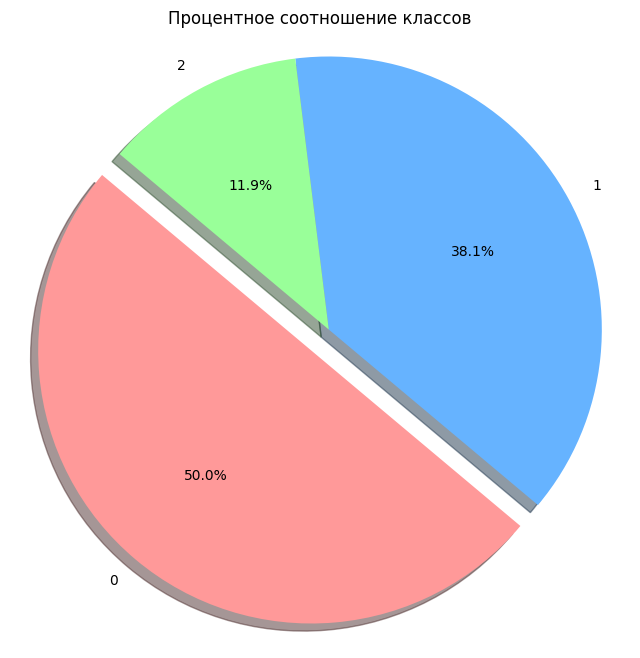

класс
0    277
1    182
2     68
Name: count, dtype: int64


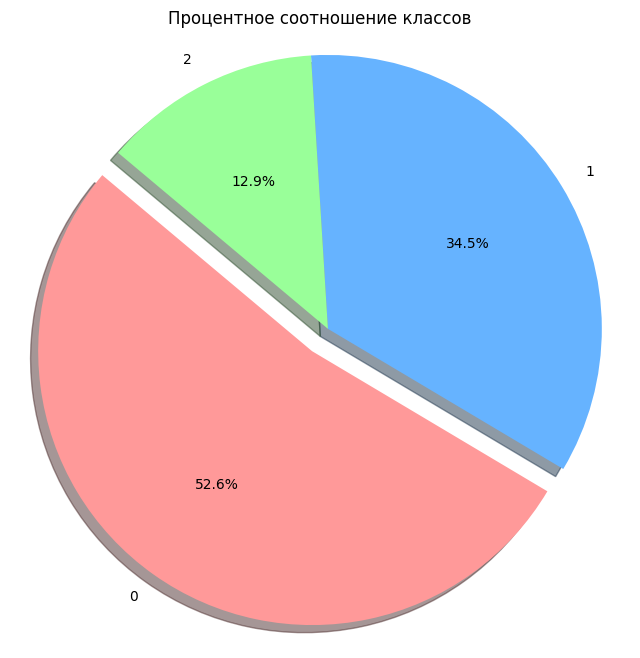

класс
0    91
1    48
2    37
Name: count, dtype: int64


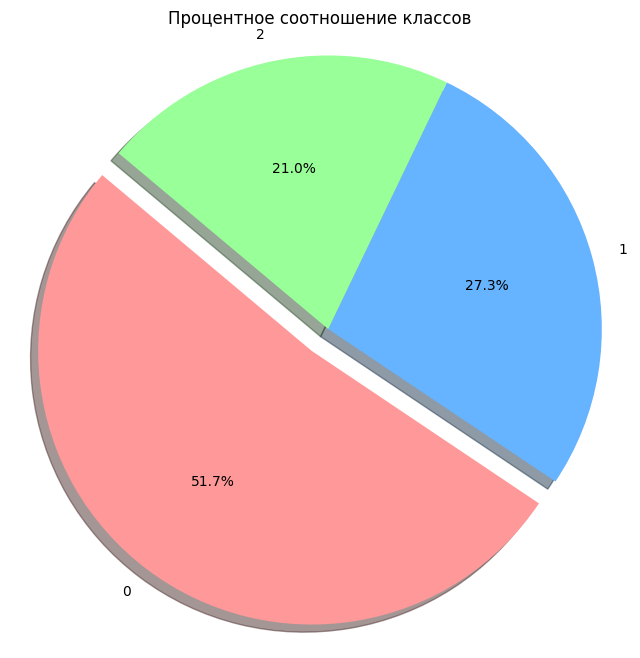

In [10]:
dataset_info(test)
dataset_info(train)
dataset_info(val)

In [12]:
# train.to_csv('train_3_class.csv', index = False)
# test.to_csv('test_3_class.csv', index = False)
# val.to_csv('val_3_class.csv', index = False)

## считываем даталоадер

In [13]:
class ROP_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label, img_name

In [14]:
# Трансформации для обучения и валидации
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
image_dir = '/content/drive/MyDrive/2_semestr/PP/augmented_images'

In [16]:
# Создание объектов датасетов
dataset_train = ROP_Dataset(dataframe=train, image_dir=image_dir, transform=transform)
dataset_test = ROP_Dataset(dataframe=test, image_dir=image_dir, transform=transform)
dataset_valid = ROP_Dataset(dataframe=val, image_dir=image_dir, transform=transform)

In [17]:
# Создание DataLoader для каждого датасета
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=False)

In [18]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of validation examples: {len(dataset_valid)}')
print(f'Number of test examples: {len(dataset_test)}')

Number of training examples: 527
Number of validation examples: 176
Number of test examples: 176


## resnet

In [30]:
# Загрузка предобученной модели ResNet18
model = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.0MB/s]


In [31]:
# Изменение последнего слоя для трехклассовой классификации
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)


In [32]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': [], 'train_rec': [], 'val_rec': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установка модели в режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Установка модели в режим оценки
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Итерация по данным
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_prec = precision_score(all_labels, all_preds, average='weighted')
            epoch_rec = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Prec: {epoch_prec:.4f} Rec: {epoch_rec:.4f} F1: {epoch_f1:.4f}')

    return model, history


In [34]:
# Обучение модели
model, history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5874 Acc: 0.7704 Prec: 0.7667 Rec: 0.7704 F1: 0.7657
val Loss: 1.0366 Acc: 0.7557 Prec: 0.8047 Rec: 0.7557 F1: 0.7236
Epoch 1/9
----------
train Loss: 0.3203 Acc: 0.8861 Prec: 0.8855 Rec: 0.8861 F1: 0.8825
val Loss: 1.9431 Acc: 0.4489 Prec: 0.7397 Rec: 0.4489 F1: 0.4180
Epoch 2/9
----------
train Loss: 0.2109 Acc: 0.9298 Prec: 0.9302 Rec: 0.9298 F1: 0.9295
val Loss: 1.1411 Acc: 0.8750 Prec: 0.8768 Rec: 0.8750 F1: 0.8702
Epoch 3/9
----------
train Loss: 0.1883 Acc: 0.9241 Prec: 0.9231 Rec: 0.9241 F1: 0.9232
val Loss: 0.5422 Acc: 0.8125 Prec: 0.8889 Rec: 0.8125 F1: 0.8126
Epoch 4/9
----------
train Loss: 0.3116 Acc: 0.9013 Prec: 0.9011 Rec: 0.9013 F1: 0.9006
val Loss: 3.2862 Acc: 0.5341 Prec: 0.6201 Rec: 0.5341 F1: 0.3903
Epoch 5/9
----------
train Loss: 0.1861 Acc: 0.9355 Prec: 0.9359 Rec: 0.9355 F1: 0.9347
val Loss: 1.1829 Acc: 0.7045 Prec: 0.7778 Rec: 0.7045 F1: 0.6690
Epoch 6/9
----------
train Loss: 0.1843 Acc: 0.9279 Prec: 0.9289 Rec: 0.9279 F1: 0

In [38]:
# Функция для тестирования модели
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    for inputs, labels, img_names in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Сохранение ошибочно классифицированных изображений
        for i in range(len(labels)):
            if preds[i].item() != labels[i].item():
                wrong_images.append(img_names[i])
                wrong_preds.append(preds[i].cpu().numpy())
                wrong_labels.append(labels[i].cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_prec = precision_score(all_labels, all_preds, average='weighted')
    test_rec = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f} Prec: {test_prec:.4f} Rec: {test_rec:.4f} F1: {test_f1:.4f}')
    return test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels


In [39]:
# Тестирование модели
test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels = test_model(model, test_loader)

Test Accuracy: 0.5227 Prec: 0.7558 Rec: 0.5227 F1: 0.3813


In [42]:
# Визуализация ошибочно классифицированных изображений
def show_wrong_images(wrong_images, wrong_preds, wrong_labels):
    plt.figure(figsize=(20, 10))
    for i in range(min(len(wrong_images), 20)):
        img = Image.open(wrong_images[i]).convert('RGB')
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {int(wrong_preds[i])}, True: {int(wrong_labels[i])}')
        plt.axis('off')
    plt.show()

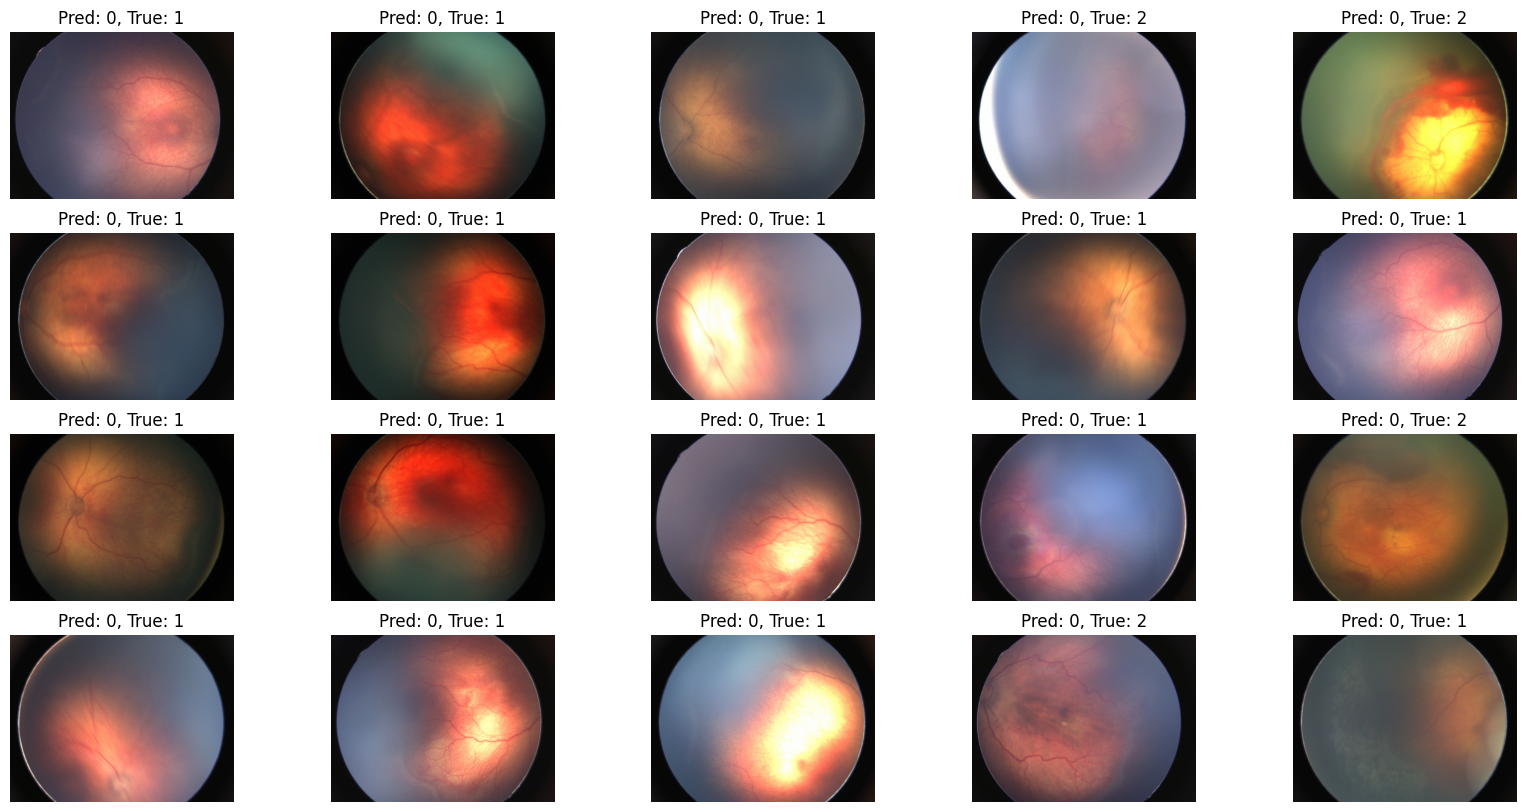

In [43]:
show_wrong_images(wrong_images, wrong_preds, wrong_labels)

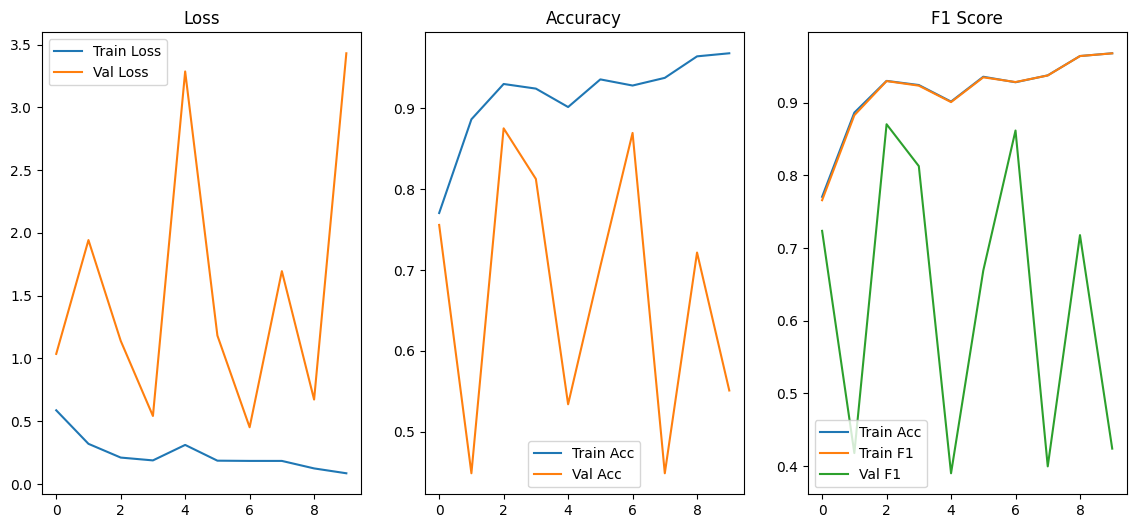

In [44]:
# Построение графиков обучения и валидации
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

# Визуализация графиков
plot_history(history)

## Effectivenet

In [45]:
# Загрузка предобученной модели EfficientNet
model = models.efficientnet_b0(pretrained=True)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 25.9MB/s]


In [46]:
# Изменение последнего слоя для трехклассовой классификации
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 3)

In [47]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [48]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': [], 'train_rec': [], 'val_rec': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установка модели в режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Установка модели в режим оценки
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Итерация по данным
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_prec = precision_score(all_labels, all_preds, average='weighted')
            epoch_rec = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Prec: {epoch_prec:.4f} Rec: {epoch_rec:.4f} F1: {epoch_f1:.4f}')

    return model, history


In [49]:
# Обучение модели
model, history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4395 Acc: 0.8254 Prec: 0.8237 Rec: 0.8254 F1: 0.8224
val Loss: 3.3088 Acc: 0.3636 Prec: 0.1944 Rec: 0.3636 F1: 0.2486
Epoch 1/9
----------
train Loss: 0.2240 Acc: 0.9203 Prec: 0.9239 Rec: 0.9203 F1: 0.9215
val Loss: 0.2218 Acc: 0.9318 Prec: 0.9376 Rec: 0.9318 F1: 0.9328
Epoch 2/9
----------
train Loss: 0.0942 Acc: 0.9715 Prec: 0.9717 Rec: 0.9715 F1: 0.9715
val Loss: 0.0812 Acc: 0.9659 Prec: 0.9697 Rec: 0.9659 F1: 0.9664
Epoch 3/9
----------
train Loss: 0.0673 Acc: 0.9810 Prec: 0.9812 Rec: 0.9810 F1: 0.9811
val Loss: 0.1318 Acc: 0.9716 Prec: 0.9716 Rec: 0.9716 F1: 0.9715
Epoch 4/9
----------
train Loss: 0.0560 Acc: 0.9810 Prec: 0.9813 Rec: 0.9810 F1: 0.9810
val Loss: 0.2442 Acc: 0.9659 Prec: 0.9697 Rec: 0.9659 F1: 0.9654
Epoch 5/9
----------
train Loss: 0.0455 Acc: 0.9810 Prec: 0.9815 Rec: 0.9810 F1: 0.9810
val Loss: 0.5624 Acc: 0.9205 Prec: 0.9384 Rec: 0.9205 F1: 0.9176
Epoch 6/9
----------
train Loss: 0.1126 Acc: 0.9602 Prec: 0.9608 Rec: 0.9602 F1: 0

In [50]:
# Функция для тестирования модели
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    for inputs, labels, img_names in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Сохранение ошибочно классифицированных изображений
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(img_names[i])
                wrong_preds.append(preds[i].cpu().numpy())
                wrong_labels.append(labels[i].cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_prec = precision_score(all_labels, all_preds, average='weighted')
    test_rec = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f} Prec: {test_prec:.4f} Rec: {test_rec:.4f} F1: {test_f1:.4f}')
    return test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels

In [51]:
# Тестирование модели
test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels = test_model(model, test_loader)

Test Accuracy: 0.9830 Prec: 0.9828 Rec: 0.9830 F1: 0.9828


In [52]:
# Визуализация ошибочно классифицированных изображений
def show_wrong_images(wrong_images, wrong_preds, wrong_labels):
    plt.figure(figsize=(20, 10))
    for i in range(min(len(wrong_images), 20)):
        img = Image.open(wrong_images[i]).convert('RGB')
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {int(wrong_preds[i])}, True: {int(wrong_labels[i])}')
        plt.axis('off')
    plt.show()

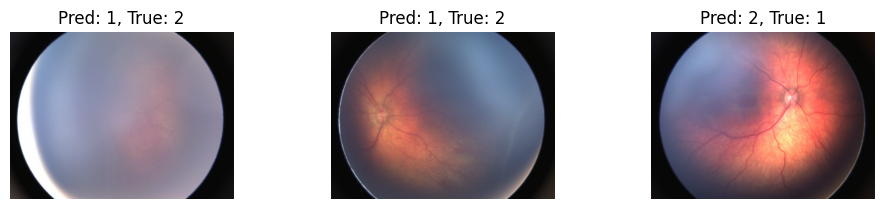

In [53]:
show_wrong_images(wrong_images, wrong_preds, wrong_labels)

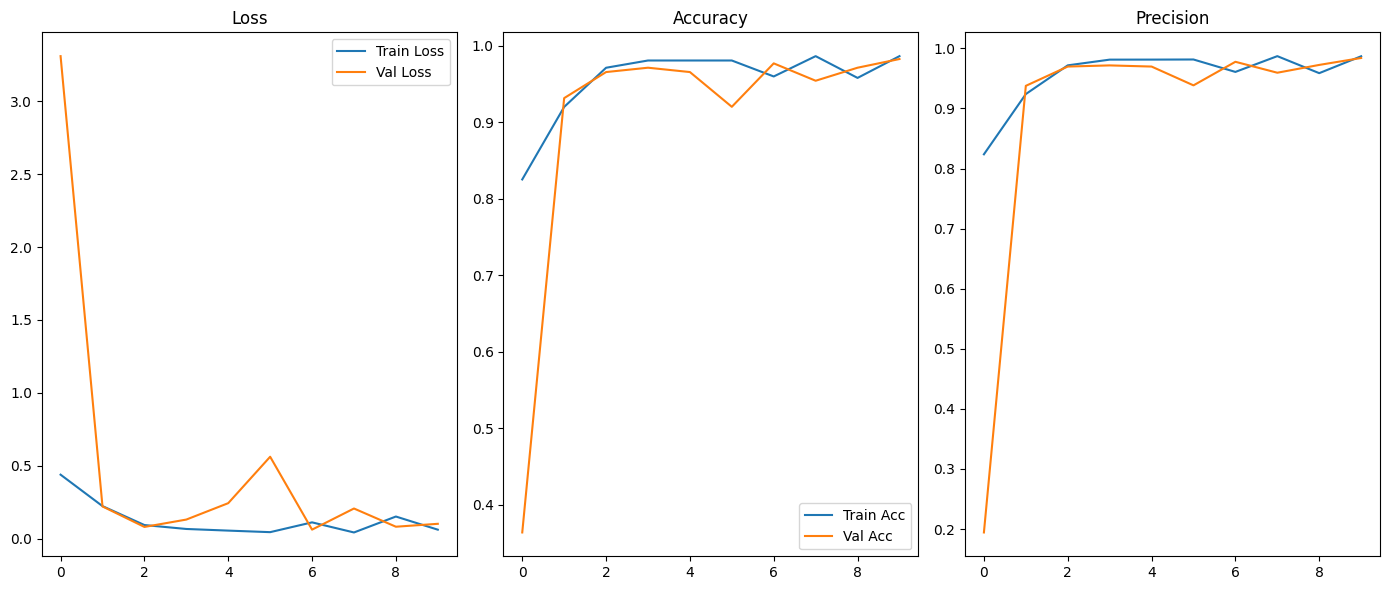

In [54]:
# Построение графиков обучения и валидации
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_prec'], label='Train Prec')
    plt.plot(epochs, history['val_prec'], label='Val Prec')
    plt.title('Precision')

    plt.tight_layout()
    plt.show()

plot_history(history)

## DenseNet121

In [19]:
# Загрузка предобученной модели DenseNet121
model = models.densenet121(pretrained=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 11.5MB/s]


In [20]:
# Изменение последнего слоя для трехклассовой классификации
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 3)

In [22]:
# Перемещение модели на GPU, если доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_prec': [], 'val_prec': [], 'train_rec': [], 'val_rec': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Каждая эпоха имеет тренировочную и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установка модели в режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Установка модели в режим оценки
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Итерация по данным
            for inputs, labels, _ in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_prec = precision_score(all_labels, all_preds, average='weighted')
            epoch_rec = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Prec: {epoch_prec:.4f} Rec: {epoch_rec:.4f} F1: {epoch_f1:.4f}')

    return model, history

In [24]:
# Обучение модели
model, history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5880 Acc: 0.7609 Prec: 0.7492 Rec: 0.7609 F1: 0.7541
val Loss: 1.5493 Acc: 0.3977 Prec: 0.6021 Rec: 0.3977 F1: 0.3309
Epoch 1/9
----------
train Loss: 0.2602 Acc: 0.9032 Prec: 0.9005 Rec: 0.9032 F1: 0.9009
val Loss: 0.3981 Acc: 0.8807 Prec: 0.8877 Rec: 0.8807 F1: 0.8737
Epoch 2/9
----------
train Loss: 0.1799 Acc: 0.9336 Prec: 0.9333 Rec: 0.9336 F1: 0.9329
val Loss: 0.6072 Acc: 0.7841 Prec: 0.8746 Rec: 0.7841 F1: 0.7801
Epoch 3/9
----------
train Loss: 0.2020 Acc: 0.9203 Prec: 0.9195 Rec: 0.9203 F1: 0.9191
val Loss: 0.3766 Acc: 0.8636 Prec: 0.9091 Rec: 0.8636 F1: 0.8690
Epoch 4/9
----------
train Loss: 0.1274 Acc: 0.9602 Prec: 0.9603 Rec: 0.9602 F1: 0.9602
val Loss: 0.6267 Acc: 0.8011 Prec: 0.8459 Rec: 0.8011 F1: 0.7891
Epoch 5/9
----------
train Loss: 0.0861 Acc: 0.9696 Prec: 0.9695 Rec: 0.9696 F1: 0.9696
val Loss: 18.7405 Acc: 0.3636 Prec: 0.2697 Rec: 0.3636 F1: 0.2494
Epoch 6/9
----------
train Loss: 0.0916 Acc: 0.9677 Prec: 0.9682 Rec: 0.9677 F1: 

In [25]:
# Функция для тестирования модели
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    wrong_images = []
    wrong_preds = []
    wrong_labels = []

    for inputs, labels, img_names in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Сохранение ошибочно классифицированных изображений
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(img_names[i])
                wrong_preds.append(preds[i].cpu().numpy())
                wrong_labels.append(labels[i].cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_prec = precision_score(all_labels, all_preds, average='weighted')
    test_rec = recall_score(all_labels, all_preds, average='weighted')
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f} Prec: {test_prec:.4f} Rec: {test_rec:.4f} F1: {test_f1:.4f}')
    return test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels

In [26]:
# Тестирование модели
test_acc, test_prec, test_rec, test_f1, wrong_images, wrong_preds, wrong_labels = test_model(model, test_loader)

Test Accuracy: 0.9375 Prec: 0.9378 Rec: 0.9375 F1: 0.9356


In [27]:
# Визуализация ошибочно классифицированных изображений
def show_wrong_images(wrong_images, wrong_preds, wrong_labels):
    plt.figure(figsize=(20, 10))
    for i in range(min(len(wrong_images), 20)):
        img = Image.open(wrong_images[i]).convert('RGB')
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(f'Pred: {int(wrong_preds[i])}, True: {int(wrong_labels[i])}')
        plt.axis('off')
    plt.show()

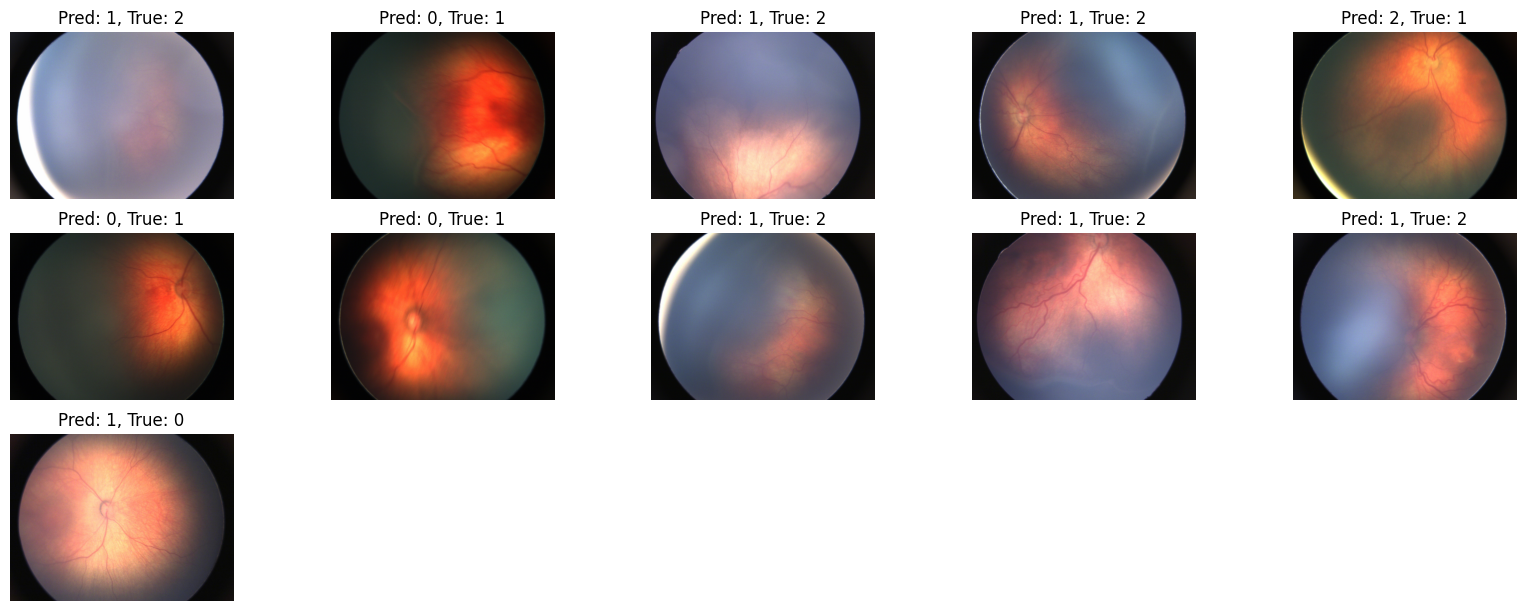

In [28]:
show_wrong_images(wrong_images, wrong_preds, wrong_labels)

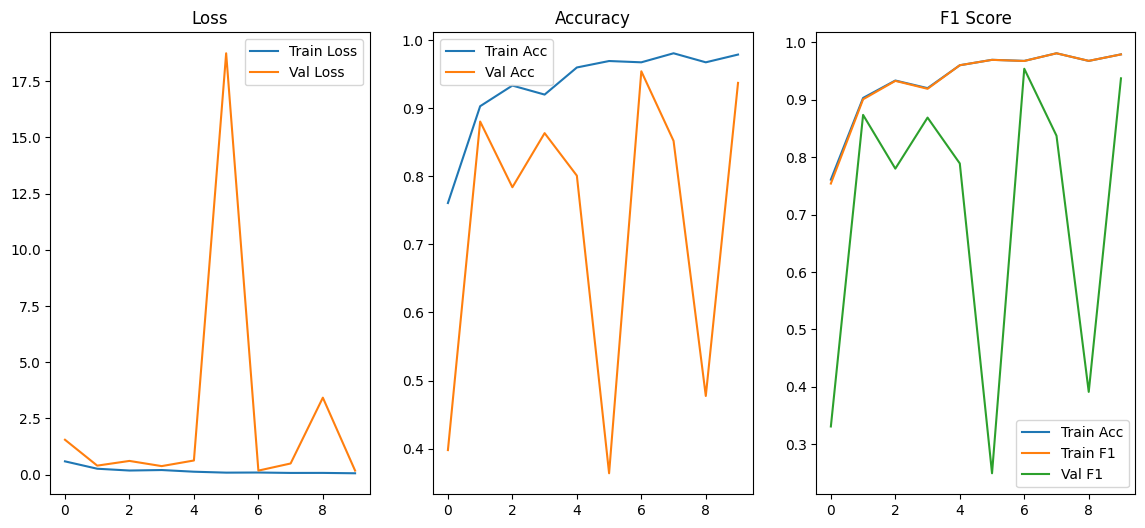

In [29]:
# Построение графиков обучения и валидации
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.show()

# Визуализация графиков
plot_history(history)